# Tweedie Models From Scratch

In [3]:
import tweedie
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
n = 200
x = np.sort(np.random.normal(size = n))
b0 = 0.1
b1 = 1
mu = np.exp(b0 + b1 * x)
# q = np.random.binomial(size = n, p = 0.1, n = 1)
# y = q * tweedie.tweedie(mu=mu, p=1.5, phi=5).rvs(n)
y = tweedie.tweedie(mu=mu, p=1.5, phi=0.5).rvs(n)

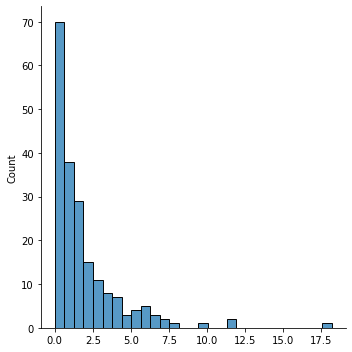

In [5]:
sns.displot(y)

<AxesSubplot:>

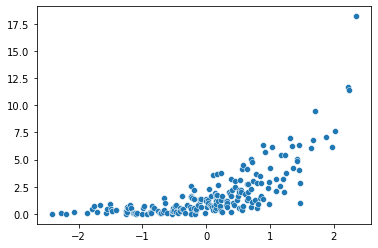

In [6]:
sns.scatterplot(x = x, y = y)

In [7]:
pd.DataFrame(y).describe()

,0
count,200.000000
mean,1.859694
std,2.359829
min,0.000000
25%,0.415380
50%,1.034595
75%,2.289224
max,18.191432


# Generalized Linear Model

### The Newton-Raphson Method

$$\hat \theta_{j+1} = \theta_j - H^{-1} l'(\theta_j)$$

where $H$ is the matrix of second derivatives of the log-likelihood with respect to $\theta$ and $l'(\theta_j)$ is the vector of first derivatives.

Here, we treat 

$$\theta = \exp \{\beta_0 + \beta_1 x_i \}$$

Our log-likelihood is 

$$l(\theta) \propto \sum_i y_i \frac{\exp^{1-p} \{\beta_0 + \beta_1 x_i\}}{1 - p} - \frac{\exp^{2-p} \{\beta_0 + \beta_1 x_i \}}{2 - p}$$

Our vector of first derivatives

$$
\begin{bmatrix}
\sum_i y_i \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - \exp^{2-p} \{\beta_0 + \beta_1 x_i \} \\
\sum_i y_i x_i \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - x_i\exp^{2-p} \{\beta_0 + \beta_1 x_i \}
\end{bmatrix}
$$

And our Hessian

$$
\begin{bmatrix}
\sum_i y_i (1-p) \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - (2-p)\exp^{2-p} \{\beta_0 + \beta_1 x_i \} & \sum_i y_i x_i (1-p) \exp^{p-1}\{\beta_0 + \beta_1 x_i\} - x_i(2-p)\exp^{2-p} \{\beta_0 + \beta_1 x_i \} \\
\sum_i y_i x_i (1-p) \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - x_i (2-p)\exp^{2-p} \{\beta_0 + \beta_1 x_i \} & \sum_i y_i x_i^2 (1-p) \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - x_i^2 (2-p)\exp^{2-p} \{\beta_0 + \beta_1 x_i \}
\end{bmatrix}
$$

### Tweedie Generalized Linear Model Algorithm

1. Initialize $\hat\theta_0 = [\hat \beta_0, \hat \beta_1] = [0, 0]$, $\epsilon = ||\theta_j - \theta_{j - 1}||$

2. While $\epsilon < \text{tol}$

    a) Compute vector of first derivatives with current parameters
    
    $\begin{bmatrix}
    \sum_i y_i \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - \exp^{2-p} \{\beta_0 + \beta_1 x_i \} \\
    \sum_i y_i x_i \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - x_i\exp^{2-p} \{\beta_0 + \beta_1 x_i \}
    \end{bmatrix}$
    
    b) Compute Hessian matrix of second derivatives with current parameters

    $
    \begin{bmatrix}
    \sum_i y_i (1-p) \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - (2-p)\exp^{2-p} \{\beta_0 + \beta_1 x_i \} & \sum_i y_i x_i (1-p) \exp^{p-1}\{\beta_0 + \beta_1 x_i\} - x_i(2-p)\exp^{2-p} \{\beta_0 + \beta_1 x_i \} \\
    \sum_i y_i x_i (1-p) \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - x_i (2-p)\exp^{2-p} \{\beta_0 + \beta_1 x_i \} & \sum_i y_i x_i^2 (1-p) \exp^{1-p}\{\beta_0 + \beta_1 x_i\} - x_i^2 (2-p)\exp^{2-p} \{\beta_0 + \beta_1 x_i \}
    \end{bmatrix}
    $

    c) Update
    
    $\hat \theta_{j+1} = \theta_j - H^{-1} l'(\theta_j)$

In [8]:
def first_derivatives(b0, b1, x, y, p):
    d_b0 = np.sum(y * np.exp(b0 + b1 * x) ** (1 - p) - np.exp(b0 + b1 * x) ** (2 - p))
    d_b1 = np.sum(y * x * np.exp(b0 + b1 * x) ** (1 - p) - x * np.exp(b0 + b1 * x) ** (2 - p))
    
    return np.array([d_b0, d_b1]).reshape(-1, 1)

In [9]:
def hessian(b0, b1, x, y, p):
    d_b02 = np.sum(y * (1 - p) * np.exp(b0 + b1 * x) ** (1 - p) - (2 - p) * np.exp(b0 + b1 * x) ** (2 - p))
    d_b12 = np.sum(y * x ** 2 * (1 - p) * np.exp(b0 + b1 * x) ** (1 - p) - x ** 2 * (2 - p) * np.exp(b0 + b1 * x) ** (2 - p))
    
    d_b0_b1 = np.sum(y * x * (1 - p) * np.exp(b0 + b1 * x) ** (1 - p) - x * (2 - p) * np.exp(b0 + b1 * x) ** (2 - p))
    
    return np.array([[d_b02, d_b0_b1],
                    [d_b0_b1, d_b12]])

In [10]:
n = 10
params = np.zeros((n, 2))

for i in range(1, n):

    b0, b1 = params[i - 1]
    p = 1.5
    
    ### Compute vector of first derivates
    d_l = first_derivatives(b0, b1, x, y, p)
    
    ### Compute matrix of hessians
    h = hessian(b0, b1, x, y, p)
    h_inv = np.linalg.inv(h)
    
    ### Update current parameters
    update = h_inv.dot(d_l).flatten()

    params[i] = params[i - 1] - update

In [11]:
params

array([[0.        , 0.        ],
       [0.11205264, 0.80582605],
       [0.11354877, 1.0289923 ],
       [0.11374388, 1.03153549],
       [0.11374394, 1.03153548],
       [0.11374394, 1.03153548],
       [0.11374394, 1.03153548],
       [0.11374394, 1.03153548],
       [0.11374394, 1.03153548],
       [0.11374394, 1.03153548]])

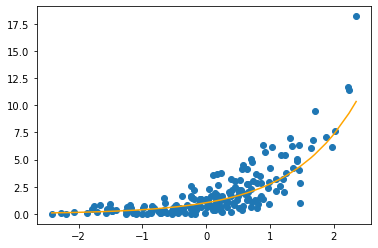

In [12]:
plt.scatter(x, y)
plt.plot(x, np.exp(0.03 + 0.98 * x), color = 'orange')
plt.show()

# Gradient Boosting Machines 
Recursively fit a decision tree to the negative gradient of the tweedie deviance of the current predictions to the observed values

Recall the general GBM algorithm

![](assets/gbm_alg.png)

The algorithm in words:

1. Start out with an initial prediction (the mean).

2. Compute the 'residuals' with this prediction.

3. Fit a simple decision tree to the 'residuals'. This decision tree minimizes the MSE.

4. Compute the optimal node value for each of the partitions given by the simple decision tree.

5. Update the current predictions and go back to step 2.



Our loss function is the tweedie deviance

$$L(\mu, y) = 2 \left(\frac{\max(0, y)^{2-p}}{(1-p)(2-p)} - \frac{y\mu^{1-p}}{1-p} + \frac{\mu^{2-p}}{2-p} \right)$$

Here we treat 

$$\mu = \exp(f(X))$$

$$L(\mu, y) = 2 \left(\frac{\max(0, y)^{2-p}}{(1-p)(2-p)} - \frac{y\exp(f(X))^{1-p}}{1-p} + \frac{\exp(f(X))^{2-p}}{2-p} \right)$$

With gradient

$$\frac{\delta L(\mu, y)}{\delta \mu} = \exp(f(X))^{(1-p)} * (\exp(f(X)) - y)$$

At the terminal nodes we solve for

$$\arg \min_\gamma \sum_{x_i \in R_{j, m}} L(y_i, \exp(f_{m - 1}(x_i) + \gamma))$$
$$\gamma_{j, m} = \log \frac{\sum_{x_i \in R_{j, m}} y_i}{\sum_{x_i \in R_{j, m}} \exp(f_{m - 1}(x_i))}$$

Updated predictions are

$$f_m(x) = f_{m - 1}(x) + \nu \sum \gamma_{j, m}I(x \in R_{j, m})$$

### Tweedie Gradient Boosting Algorithm

1. Initialize $f_0(x) = \bar y$

2. For $m=1$ to $M$

    a) For $i = 1, ..., N$ compute
    
    $r_{im} = \exp(f(x_i))^{(1-p)}(\exp(f(x_i)) - y)$
    
    b) Fit a regression tree to $r_{im}$
    
    c) For $j = 1, ..., J_m$ compute 
    
    $\gamma_{j, m} = \log \frac{\sum_{x_i \in R_{j, m}} y_i}{\sum_{x_i \in R_{j, m}} \exp(f_{m - 1}(x_i))}$
    
    d) Update
    
    $f_m(x) = f_{m - 1}(x) + \nu \sum \gamma_{j, m}I(x \in R_{j, m})$

In [13]:
def tweedie_grad(y, mu, p = 1.5):

    return np.exp(mu) ** (1 - p) * (np.exp(mu) - y)

In [14]:
def tweedie_deviance(y_pred, y_true, p = 1.5):
    # Requires y_pred > 0 and y_true >= 0
    y_pred = np.exp(y_pred)
    dev = 2 * (
        np.power(y_true, 2 - p) / ((1 - p) * (2 - p))
        - y_true * np.power(y_pred, (1 - p)) / (1 - p)
        + np.power(y_pred, (2 - p)) / (2 - p)
    )
    
    return np.mean(dev)

In [15]:
def fit_weak_tree(X, psuedo_r):
    weak_tree = tree.DecisionTreeRegressor(max_depth = 2)
    weak_tree.fit(X, psuedo_r)
    terminal_regions = weak_tree.apply(X)
    
    return weak_tree, terminal_regions

In [16]:
def assign_terminal_node_values(terminal_regions, y, current_predictions):
    possible_regions = np.unique(terminal_regions)
    gammas = np.zeros(len(y))
    for region in possible_regions:
        in_terminal_region = region == terminal_regions
        y_in_node = y[in_terminal_region]
        current_predictions_in_node = current_predictions[in_terminal_region]
        gammas[in_terminal_region] = max(np.log(np.sum(y_in_node) / np.sum(np.exp(current_predictions_in_node))), -20)
        
    return gammas

In [17]:
from sklearn import tree

/tmp/ipykernel_26197/1204102924.py:8: RuntimeWarning: divide by zero encountered in log
  gammas[in_terminal_region] = max(np.log(np.sum(y_in_node) / np.sum(np.exp(current_predictions_in_node))), -20)
/tmp/ipykernel_26197/1204102924.py:8: RuntimeWarning: divide by zero encountered in log
  gammas[in_terminal_region] = max(np.log(np.sum(y_in_node) / np.sum(np.exp(current_predictions_in_node))), -20)
/tmp/ipykernel_26197/1204102924.py:8: RuntimeWarning: divide by zero encountered in log
  gammas[in_terminal_region] = max(np.log(np.sum(y_in_node) / np.sum(np.exp(current_predictions_in_node))), -20)
/tmp/ipykernel_26197/1204102924.py:8: RuntimeWarning: divide by zero encountered in log
  gammas[in_terminal_region] = max(np.log(np.sum(y_in_node) / np.sum(np.exp(current_predictions_in_node))), -20)
/tmp/ipykernel_26197/1204102924.py:8: RuntimeWarning: divide by zero encountered in log
  gammas[in_terminal_region] = max(np.log(np.sum(y_in_node) / np.sum(np.exp(current_predictions_in_node))), 

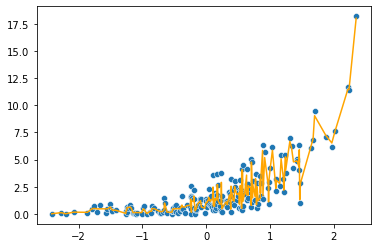

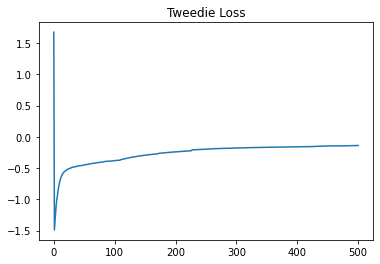

In [18]:
### Params
max_trees = 500
learn_rate = 0.1

### Initial Predictions
F0 = np.log(np.mean(y))
current_predictions = np.repeat(F0, len(y))
psuedo_r = tweedie_grad(y, current_predictions)
X = x.reshape(-1, 1)

### Initial Loss
tweedie_loss = [None for i in range(max_trees + 1)]
tweedie_loss[0] = tweedie_deviance(current_predictions, y)

for T in range(1, max_trees + 1):
    
    ### Fit weak tree to psuedo residuals
    current_tree, current_terminal_regions = fit_weak_tree(X, psuedo_r)

    ### Compute Terminal Node Values
    gammas = assign_terminal_node_values(current_terminal_regions, y, current_predictions)

    ### Update Predictions
    current_predictions += learn_rate * gammas
    
    ### Psuedo Residuals (negative gradient)
    psuedo_r = tweedie_grad(y, current_predictions)
    
    ### Track Loss
    tweedie_loss[T] = -tweedie_deviance(current_predictions, y)
    
sns.scatterplot(x = x, y = y)
plt.plot(x, np.exp(current_predictions), color = 'orange')

plt.figure()
plt.title('Tweedie Loss')
plt.plot(tweedie_loss)
plt.show()